In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import folium
import pickle

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Create some function that are neccessary for later on.

In [2]:
from math import radians, sin, cos, sqrt, atan2
# function that finds he distance between two coordinates
def haversine_distance(coordinates):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = coordinates
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius = 6371  # Earth's radius in kilometers
    distance = radius * c

    return distance


from geopy.geocoders import Nominatim
# function that finds the coordinates of an adress
loc = Nominatim(user_agent="GetLoc")

Getting the infomration for each apartmnet. This does not include coordinates or whether it is shareable or not

In [13]:
def apartments(number_sites=10):
    def apartments_details(url):    
        # get access to the site
        response = requests.get(url)

        # Create a BeautifulSoup object and specify the parser
        soup = BeautifulSoup(response.text, "html.parser")
        block = soup.find_all('div',class_="css-ho2tek")


        # scrape boligportal site and get all the info of the apartments there        
        details = {'id':[],'location':[],'rooms':[],'type':[],'size':[],'time':[],'rent':[],'comments':[],'link':[]}
        times = ['hour','minutes','days','esterday','january','february','march','april','may','june','july','august','september','october','november','december']
        for i in block:
            blockII = i.find_all('div')
            if len(blockII) != 1:
                for j in blockII:
                    blockIII = j.find_all('div')
                    for z in blockIII:
                        for a in blockIII:
                            blockIV = a.find_all('a',class_='AdCardSrp__Link css-17x8ssx')
                            if len(blockIV) != 0:
                                for b in blockIV:
                                    bI = b
                                    link = 'https://www.boligportal.dk{}'.format(b.get("href"))
                                    id_ = b.get("href").split('id-')[1]    
                                    details['id'].append(id_)
                                    details['link'].append(link)                                                            


                                details_ = bI.find_all('div',class_='css-js2eza')
                                location = bI.find_all('div',class_='css-1w4wg57')
                                comments = bI.find_all('div',class_='css-11zpaaj')
                                price = bI.find_all('div',class_='css-btz01o')

                                for l in details_:                                
                                    l = l.text.split()
                                    num_rooms = l[0]
                                    type_ = l[3]
                                    size = l[5]
                                    try:
                                        details['rooms'].append(num_rooms)
                                        details['type'].append(type_)
                                        details['size'].append(size)
                                    except:          
                                        # sometimes there are rooms and half (2.5). Pass it as a float instead of int                      
                                        num_rooms = num_rooms.replace(',','.')
                                        details['rooms'].append(num_rooms)
                                        details['type'].append(type_)
                                        details['size'].append(size)


                                for l in location:
                                    details['location'].append(l.text)                                
                                for l in comments:
                                    details['comments'].append(l.text)                        
                                for l in price:                    
                                    # print(l.text)        
                                    if 'Yesterday' in l.text:
                                        l = l.text.split('Yesterday')     
                                        details['time'].append('Yesterday')   
                                    else:      
                                        l = l.text.split('ago')                     
                                        details['time'].append(l[0].strip())   
                                    # print(l)                     
                                    # print(l[1]) 
                                    #    
                                    try:                    
                                        details['rent'].append(float(l[1].split()[0]))                                           
                                    except:
                                        # the dates are no longer in terms of hour, minutes,yesterday or days but in months. Split by months
                                        l = l[0]
                                        months = ['january','february','march','april','may','june','july','august','september','october','november','december']
                                        for i in months:
                                            l = l.lower()
                                            if i in l:
                                                # print(l)
                                                pr = l.split(i)
                                                details['rent'].append(float(pr[1].split()[0]))
                                # print(details)
        

        # put all the lists into one big list
        detailsII = list(set(zip(details['id'],details['location'],details['rooms'],details['type'],details['size'],details['time'],details['rent'],details['comments'],details['link'])))
        dic = {k:[] for k in details} 
        for i in detailsII:
            for j in range(len(i)):
                dic[list(dic.keys())[j]].append(i[j])
        
        # mkaing a df with all the gained info
        df = pd.DataFrame(dic)
        # add acolumn ratio where we see how much each person would have to pay
        
        arr = np.array([int(i) if i is isinstance(i,int) else float(i.replace(',','.')) for i in df.rooms])
        
            
        arr[np.where(arr == 1)] = 2
        df['ratio (1000 DKK)/person'] = np.round(np.array(list(df.rent))/np.array([i-1 for i in arr]),2)

        # add a column for at which site the said apartment was found
        if len(url.split('=')) >= 2:
            df['site_num'] = [url.split('=')[-1]]*df.shape[0]    
        else:
            df['site_num'] = ['main_site']*df.shape[0]    



        return df                                            

    # df = apartments_details(url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/")
    # df

    all_apartments = []
    print('### Start ###')
    print('\tGoing through {} BoligPortal websites'.format(number_sites))
    for i in tqdm(range(number_sites)):
        sleep(0.00000000000000000000000000001)
        if i == 0:
            url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/"
        else: 
            url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/?offset={}".format(18*i)
        all_apartments.append(apartments_details(url))
    df = pd.concat(all_apartments,axis=0)
    df = df.drop_duplicates().reset_index(drop=True)
    print('### Done ###')
    return df

df = apartments(number_sites=100)
df.iloc[:5]

### Start ###
	Going through 100 BoligPortal websites


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]

### Done ###


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num
0,5230021,"København K, Frederiksborggade",1,Room,10,2 hours,5.50,Hyggelig værelse ved Nørreport i Kbh / Cosy ro...,https://www.boligportal.dk/en/rental-rooms/k%C...,5.50,main_site
1,5363646,"Valby, Gammel Jernbanevej",1,Apartment,31,2 hours,7.95,Lejlighed med stor fælles tagterrasse,https://www.boligportal.dk/en/rental-apartment...,7.95,main_site
2,5268772,"København SV, Linus Paulings Vej",5,Apartment,130,2 hours,22.55,The Residence CPH - Moderne 5-værelses lejebol...,https://www.boligportal.dk/en/rental-apartment...,5.64,main_site
3,5363647,"København S, Emma Gads Vej",2,Apartment,60,2 hours,12.20,Lindgrens Hus – Det nye centrum i Bellakvarter,https://www.boligportal.dk/en/rental-apartment...,12.20,main_site
4,5363662,"Vallensbæk Strand, Amalieparken",4,Apartment,129,1 hour,15.50,Amalieparken - Flot 4V’er med egen altan - vel...,https://www.boligportal.dk/en/rental-apartment...,5.17,main_site


Now we get the coordinates of the different places

In [14]:
def coordinates(df=df):
    # here is where we are going to save the coordinates so that we do onthave to run the cell below all the time
    # Open/load the pickle file back into Python
    with open('coordinated.pickle', 'rb') as file:
    # with open('coordinated.pickle', 'rb') as file:
        loaded_coordinates = pickle.load(file)
    print('### Pickle epened ###')
    print('Number of coordinates: {}'.format(len(loaded_coordinates)))



    # add a column for the coordinates of the different places
    # iterate thorugh every location and gets its coordinate. The ones where there is an error is because the library cannot identify said address
    def setting_coordinates(df,coordinates:dict):
        locations = set(list(df.location))

        for i in tqdm(locations):
            sleep(0.00000000000000000000000000001)
            if i not in list(coordinates.keys()):
                # print(i,'Found in location:',np.where(np.array(list(coordinates.keys())) == i))
                try:
                    coordinates[i] = loc.geocode(i).point[:2]
                except: 
                    coordinates[i] = "Error"
                    
        # getLoc = loc.geocode("IT University of Copenhaguen")    
        getLoc = loc.geocode("Nordhavn Station")

        # do this for the apartments and IT university
        df['Coordinates'] = [coordinates[i] for i in df.location]
        df['ITU_coordinates'] = [getLoc.point[:2]]*df.shape[0]

        # calculate the distance between each house and ITU
        distance = lambda i:round(haversine_distance(df.iloc[i].Coordinates+df.iloc[i].ITU_coordinates),2)
        distances = []

        for i in range(df.shape[0]):    
            try:
                distances.append(float(distance(i)))
            except:
                distances.append('Error')
        df['Distance (km)'] = distances

        # order the df based on the ratio
        df = df.sort_values('ratio (1000 DKK)/person')    
        
        # see if id is one of the columns and make sure that we do not repeat this column
        if 'id' not in list(df.columns):
            df = df.reset_index()
            df = df.rename(columns={'index': 'id'})
        else:
            df = df.reset_index(drop=True)

        return df,coordinates

    print('\n### Start ###')
    print('\tGetting the coordinates of addresses')
    df,coordinates = setting_coordinates(df,coordinates=loaded_coordinates)
    print('### Done ###')


    # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
    with open('coordinated.pickle', 'rb') as file:
    # with open('coordinated.pickle', 'rb') as file:
        loaded_coordinates = pickle.load(file)

    # Save the dictionary as a pickle file if the pickled dict is smaller than the just made dict
    if len(loaded_coordinates) < len(coordinates):
        print('\n### Saving new coordinates ###')
        with open('coordinated.pickle', 'wb') as file:
        # with open('coordinated.pickle', 'wb') as file:
            pickle.dump(coordinates, file)
        print('New pickled number of coordinates: {}'.format(len(coordinates)))
        print('Done')
    
    return df

df = coordinates(df=df)
df.iloc[:5]

### Pickle epened ###
Number of coordinates: 710

### Start ###
	Getting the coordinates of addresses


100%|██████████| 697/697 [00:00<00:00, 34021.46it/s]


### Done ###


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km)
0,5358031,"Taastrup, Snubbekorsvej",8,House,258,10 May18.000 kr.,18.0,Villa i Høje Taastrup,https://www.boligportal.dk/en/rental-houses/k%...,2.57,1134,"(55.6698684, 12.2874444)","(55.7074271, 12.5915656)",19.51
1,5361954,"København N, Fogedmarken",1,Room,10,6 days,3.0,Stort lyst værelse med fransk altan og fantast...,https://www.boligportal.dk/en/rental-rooms/k%C...,3.00,468,"(55.7005625, 12.554185)","(55.7074271, 12.5915656)",2.46
2,5361942,"København N, Thorsgade",4,Apartment,89,29 May9.000 kr.,9.0,Lejlighed til leje i juli måned / Apartment fo...,https://www.boligportal.dk/en/rental-apartment...,3.00,522,"(55.6975182, 12.5492806)","(55.7074271, 12.5915656)",2.87
3,5363558,"Gentofte, Lyngbyvej",1,Room,6,6 hours,3.0,Room in central Gentofte for rent,https://www.boligportal.dk/en/rental-rooms/k%C...,3.00,54,"(55.7402769, 12.5373373)","(55.7074271, 12.5915656)",4.99
4,5360474,"København K, Strandgade",1,Room,12,22 May3.000 kr.,3.0,Pendler værelse,https://www.boligportal.dk/en/rental-rooms/k%C...,3.00,810,"(55.6774167, 12.5967105)","(55.7074271, 12.5915656)",3.35


Now we have to add some additional information, such as if they are sharabale or not and other stuff like that...

In [15]:
def sharable(df=df,n=df.shape[0]):
    # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
    with open('shareable_info.pickle', 'rb') as file:
    # with open('coordinated.pickle', 'rb') as file:
        shareable_info_pickled = pickle.load(file)

    # make a dictionary with all the required information for the url. All you must do i give the row index as an argument
    def url_arguments_dic(df,n=0):
        row = n
        url_dic = {'type':0,'size':0,'n_rooms':0,'id':0}
        if df.iloc[row].type == 'Apartment':
            url_dic['type'] = 'apartments'
        elif df.iloc[row].type == 'Room':
            url_dic['type'] = 'rooms'
        url_dic['size'] = df.iloc[row]['size']
        try:
            url_dic['n_rooms'] = int(df.iloc[row]['rooms'])
        except:
            url_dic['n_rooms'] = float(df.iloc[row]['rooms'].replace(',','.'))
        url_dic['id'] = int(df.iloc[row]['id'])
        return url_dic


    # now out the two functions together in this one to get the info from the page
    def apartments_extra_info_extraction(df,n=5):
        d = url_arguments_dic(df=df,n=n)
        url = "https://www.boligportal.dk/en/rental-{}/k%C3%B8benhavn/{}m2-{}-room-id-{}".format(d['type'],d['size'],d['n_rooms'],d['id'])
        response = requests.get(url)

        # Create a BeautifulSoup object and specify the parser
        soup = BeautifulSoup(response.text, "html.parser")    
        sharable = soup.find_all('div',class_='css-h1x6rg')

        info = {}
        for i in sharable:
            try:
                info_type = i.find_all('span',class_='css-arxwps')[0].text
                info_answ = i.find_all('span',class_='css-1h46kg2')[0].text
                info[info_type] = info_answ
            except: pass    
        return info


    def adding_extra_info(n=df.shape[0],pickle=shareable_info_pickled):#n=df.shape[0]
        # change the df into a pickle form
        pickle = dict(zip(pickle['Listing-id'],pickle['Shareable']))
        # to run all the functions above all you have to do is run this one. There is no need to touch anything else
        extra_info_dic = apartments_extra_info_extraction(df=df,n=0)
        print("### Starting extra info extraction ###")
        # now run the functions with all the rows so we get all the additinal info
        info = {}
        pickled_aparments = list(pickle.keys())
        for i in tqdm(range(n)):
            sleep(0.0000000000000000000000001)  
            # check if the infomration is in the pickle so we do not have to get tis info again in the future
            if df.iloc[i]['id'] in pickled_aparments:
                info[df.iloc[i]['id']] = pickle[df.iloc[i]['id']]
            else:
                extra_info_dic = apartments_extra_info_extraction(df=df,n=i)
                if 'Shareable' and 'Listing-id' in list(extra_info_dic.keys()):
                    info[extra_info_dic['Listing-id']] = extra_info_dic['Shareable']
            
        # keep only the features which every apartment has info about and make a df out of that
        # extra_info_to_use = list(np.array(list(info.keys()))[np.where(np.array([len(v) for v in info.values()]) == n-1)])
        extra_info = pd.DataFrame({'Listing-id':list(info.keys()),'Shareable':list(info.values())})

        # now find those which are sharable and get the ids for them to put later on the real df
        sharable_ids = extra_info[extra_info['Shareable'] == 'Yes']['Listing-id']

        ids = []
        for i in sharable_ids:
            ids.append(np.where(np.array(list(df['id'])) == i)[0][0])
        ids

        shareable_binary = []
        for i in range(df.shape[0]):
            if i in ids:
                shareable_binary.append(1)
            else:
                shareable_binary.append(0)

        df['Shareable'] = shareable_binary

        print("### Done ###")
        return df,extra_info
    
    df,extra_info = adding_extra_info()    

    # as previosuly done, if the new dic has more info than the one pickled then replace it
    # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
    with open('shareable_info.pickle', 'rb') as file:
    # with open('coordinated.pickle', 'rb') as file:
        loaded_coordinates = pickle.load(file)

    # Save the dictionary as a pickle file if the pickled dict is smaller than the just made dict
    if len(loaded_coordinates) < len(extra_info):
        print('\n### Saving new coordinates ###')
        with open('shareable_info.pickle', 'wb') as file:
        # with open('coordinated.pickle', 'wb') as file:
            pickle.dump(extra_info, file)
        print('Done')
    return df

df = sharable(df=df,n=df.shape[0])
df.iloc[:5]

### Starting extra info extraction ###


100%|██████████| 1800/1800 [00:22<00:00, 80.12it/s] 


### Done ###


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5358031,"Taastrup, Snubbekorsvej",8,House,258,10 May18.000 kr.,18.0,Villa i Høje Taastrup,https://www.boligportal.dk/en/rental-houses/k%...,2.57,1134,"(55.6698684, 12.2874444)","(55.7074271, 12.5915656)",19.51,0
1,5361954,"København N, Fogedmarken",1,Room,10,6 days,3.0,Stort lyst værelse med fransk altan og fantast...,https://www.boligportal.dk/en/rental-rooms/k%C...,3.00,468,"(55.7005625, 12.554185)","(55.7074271, 12.5915656)",2.46,0
2,5361942,"København N, Thorsgade",4,Apartment,89,29 May9.000 kr.,9.0,Lejlighed til leje i juli måned / Apartment fo...,https://www.boligportal.dk/en/rental-apartment...,3.00,522,"(55.6975182, 12.5492806)","(55.7074271, 12.5915656)",2.87,0
3,5363558,"Gentofte, Lyngbyvej",1,Room,6,6 hours,3.0,Room in central Gentofte for rent,https://www.boligportal.dk/en/rental-rooms/k%C...,3.00,54,"(55.7402769, 12.5373373)","(55.7074271, 12.5915656)",4.99,1
4,5360474,"København K, Strandgade",1,Room,12,22 May3.000 kr.,3.0,Pendler værelse,https://www.boligportal.dk/en/rental-rooms/k%C...,3.00,810,"(55.6774167, 12.5967105)","(55.7074271, 12.5915656)",3.35,0


Take a look at what the best options are. Ideally, something like paying less than 5.5k DKK and is ess than 5 km away from ITU

In [16]:
def best_options(df,max_rent=5.5,max_dist=5,sharable=True):    
    best_options = df
    orignal_size = best_options.shape[0]
    best_options['Distance (km)'] = best_options['Distance (km)'].replace('Error', 9999)
    best_options = best_options[(best_options['ratio (1000 DKK)/person'] < max_rent) & (best_options['Distance (km)'] < max_dist)]
    best_options = best_options[(best_options['type']) == 'Apartment' ]
    # check if we are interested findng those which are shareable or not
    if sharable:
        best_options = best_options[(best_options['Shareable']) == 1 ]
    print('Ratio of best options: {}%'.format(round(best_options.shape[0]/orignal_size*100,2)))

    best_options = best_options.reset_index(drop=True)
    pd.set_option('display.max_rows', 50)
    return best_options

best_options_df = best_options(df=df,max_rent=7,max_dist=10,sharable=True)
best_options_df = best_options_df[best_options_df.rooms == '3']
best_options_df = best_options_df.reset_index(drop=True)
best_options_df

Ratio of best options: 5.22%


,id,location,rooms,type,size,time,rent,comments,link,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5297539,"Charlottenlund, Broholms Alle",3,Apartment,69,21 hours,9.500,Hyggelig lejlighed,https://www.boligportal.dk/en/rental-apartment...,4.75,72,"(55.7606543, 12.5828513)","(55.7074271, 12.5915656)",5.94,1
1,4808974,"Hellerup, Tuborgvej",3,Apartment,90,27 April10.000 kr.,10.000,Lys og lækker kælder-lejlighed i Hellerup leje...,https://www.boligportal.dk/en/rental-apartment...,5.00,1476,"(55.727107, 12.5502141)","(55.7074271, 12.5915656)",3.39,1
2,5333379,"Valby, Søndre Allé",3,Apartment,60,28 April11.000 kr.,11.000,60 sqm apartment fully renovated and furnished,https://www.boligportal.dk/en/rental-apartment...,5.50,1458,"(55.6666277, 12.4970786)","(55.7074271, 12.5915656)",7.46,1
3,5355741,"Gentofte, Smakkegårdsvej",3,Apartment,79,1 May11.185 kr.,11.185,"Nyistandsat 3-værelses i rolig ejendom, tæt på...",https://www.boligportal.dk/en/rental-apartment...,5.59,1422,"(55.755654, 12.5397932)","(55.7074271, 12.5915656)",6.27,1
4,4805352,"Rødovre, Tårnvej",3,Apartment,73,26 April11.900 kr.,11.900,"3V lejlighed, Super beliggenhed tæt på Rødovre...",https://www.boligportal.dk/en/rental-apartment...,5.95,1530,"(55.670518, 12.4566161)","(55.7074271, 12.5915656)",9.40,1
5,5265016,"Rødovre, Møllevangen",3,Apartment,72,5 days,11.900,"SMUKT LYSINDFALD, EGEN ALTAN, FRI PARKERING",https://www.boligportal.dk/en/rental-apartment...,5.95,360,"(55.7050794, 12.4347919)","(55.7074271, 12.5915656)",9.83,1
6,5352943,"Rødovre, Rødovre Parkvej",3,Apartment,73,19 April12.000 kr.,12.000,3-værelses indflytningsklar lejlighed til leje...,https://www.boligportal.dk/en/rental-apartment...,6.00,1746,"(55.6804471, 12.4576797)","(55.7074271, 12.5915656)",8.91,1
7,5281265,"København S, Bremensgade",3,Apartment,67,12 May12.000 kr.,12.000,Lys delevenlig 3 vær lejlighed tæt på Amagerbr...,https://www.boligportal.dk/en/rental-apartment...,6.00,1062,"(55.6654179, 12.6165873)","(55.7074271, 12.5915656)",4.93,1
8,5361758,"Rødovre, Gunnekær",3,Apartment,73,26 May12.100 kr.,12.100,3 værelses lejlighed på Gunnekær i Rødovre udl...,https://www.boligportal.dk/en/rental-apartment...,6.05,558,"(55.6829018, 12.4608801)","(55.7074271, 12.5915656)",8.63,1
9,5360534,"Herlev, Lyskær",3,Apartment,80,22 May12.095 kr.,12.095,Nybygget lejlighed i Herlev til ubegrænset leje,https://www.boligportal.dk/en/rental-apartment...,6.05,792,"(55.7139154, 12.4330296)","(55.7074271, 12.5915656)",9.96,1


Now we are going to plot a map with the different coordinates

In [17]:
def plot_map(df):
    p = df
    # p = df.iloc[:]
    p = p[p['Coordinates'] != 'Error']
    # List of coordinates
    coordinates = list(p['Coordinates'])

    # Calculate the center of the coordinates
    center_lat = sum(lat for lat, _ in coordinates) / len(coordinates)
    center_lon = sum(lon for _, lon in coordinates) / len(coordinates)

    # Create a map object with the calculated center
    map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # Add markers to the map
    count = 0
    for coord in coordinates:        
        focus = p.iloc[count]     
        # popup="<a href=https://fr.wikipedia.org/wiki/Place_Guillaume_II>Place Guillaume II</a>",
        # popup_marker = '<a href={}>ClickHere</a>'.format(focus['link'])   
        # popup_mark = popup_marker(map,focus)
        # print(popup_mark)
        link_html = '''
            <a href={} target="_blank">
                Click Here
            </a>
            '''.format(focus['link'])
        # folium.Marker(location=coord,tooltip={'Location':focus.location,'Rent':focus.rent,'Rooms':focus.rooms}, popup=popup_content).add_to(map)
        folium.Marker(location=coord,tooltip={'Location':focus.location,'Rent':focus.rent,'Rooms':focus.rooms,'idx':count}, popup=folium.Popup(link_html)).add_to(map)
        count += 1
        
    folium.Marker(location=list(p.ITU_coordinates)[0], tooltip='ITU', popup='Marker Popup', icon=folium.Icon(color='red')).add_to(map)

    # Adjust the CSS styling of the map container
    # map._repr_html_ = map._repr_html_().replace('style="', 'style="width:50%; height:50%;')
    # Display the map
    return map
plot_map(df=best_options_df)

Now we are going to take a look at the different apartments that we are interested in. It has an id as a key and a link as a value. Notice it is in the form of a pickled dictionary

In [ ]:
def modify_favorites(fav_id:list,delete_id:list):
    # open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
    with open('../favorites.pickle', 'rb') as file:
    # with open('coordinated.pickle', 'rb') as file:
        pickled_favs = pickle.load(file)

    favs = pickled_favs    
    # go thorugh the ids that you are interested in and add them to the pickled dictionary
    for i in fav_id:
        if i not in list(favs.keys()):
            focus = best_options_df.iloc[i]
            favs[focus['id']] = focus['link']

    # if you want to delete any ids, 
    if len(delete_id) != 0:
        for i in delete_id:
            if i in list(favs.keys()):
                del favs[i]    


    with open('../favorites.pickle', 'wb') as file:
    # with open('coordinated.pickle', 'wb') as file:
        pickle.dump(favs, file)    
    
    return favs

favs = modify_favorites(fav_id=[15],delete_id=[])     
favs

{'5288687': 'https://www.boligportal.dk/en/rental-apartments/k%C3%B8benhavn/83m2-3-room-id-5288687'}

Now that we have a dataset with all the apartments in BoligPortal, we can look at the data and filter it as we want

In [ ]:
# this function 
def target(n_rooms = 1,threshold_hours=10,threshold_time=True):
    # select how many roowms you want to look at    
    indeces = np.where((np.array(list(df.rooms)) == n_rooms) & (np.array(list(df.type)) == 'Apartment'))
    indeces = np.where((np.array(list(df.rooms)) == n_rooms))
    print('\tNumber of places with {} rooms: {}'.format(n_rooms,len(list(indeces[0]))))
    # selet if you want to show the whole df or not
    show_all = True
    if show_all:
        pd.set_option('display.max_rows', None)
    target = df.iloc[list(indeces[0])]

    if threshold_time:        
        times = []
        for i in target['time']:
            print(i)
            if 'hour' in i:
                times.append(int(i.split()[0]))
            elif 'min' in i:
                times.append(int(i.split()[0])/60)
            else:
                times.append(i)
        
        threshold_times = [1 if isinstance(i, int) and i < threshold_hours else 0 for i in times]
        threshold_times_idx = list(np.where(np.array(threshold_times) == 1)[0])
        print('\tNumber of places posted <= {} hours ago: {}'.format(threshold_hours,len(threshold_times_idx)))
        return target.iloc[threshold_times_idx]
    else: 
        return target

check_all_options = True
if check_all_options:
    for i in range(1,10):
        print('\nNumber rooms:',i)
        result = target(n_rooms = i,threshold_hours=90,threshold_time=True)
        if result.shape[0] != 0:            
            display(result)


Number rooms: 1
	Number of places with 1 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 2
	Number of places with 2 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 3
	Number of places with 3 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 4
	Number of places with 4 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 5
	Number of places with 5 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 6
	Number of places with 6 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 7
	Number of places with 7 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 8
	Number of places with 8 rooms: 0
	Number of places posted <= 90 hours ago: 0

Number rooms: 9
	Number of places with 9 rooms: 0
	Number of places posted <= 90 hours ago: 0


Now we are going to try find a balance between the rent and how far away the apartments are

In [ ]:
# i would not recommend using this one too much
def price_distance_balance(df):
    # create a copy of the df and order it in terms of distance
    dff = df
    dff = dff.drop('id',axis=1)
    dff['Distance (km)'] = dff['Distance (km)'].replace('Error', 9999)
    dff = dff.sort_values('Distance (km)')
    dff = dff.reset_index()
    dff = dff.rename(columns={'index': 'id'})

    # the rank of aprtments in terms of closeness, how far are they in terms of expensiveness?
    # take both price and how far it is into consideration and put it into a dic
    cheapest = dict(enumerate(df.id))
    cheapest = {v:k+1 for k,v in cheapest.items()}

    closest = dict(enumerate(dff.id))
    closest = {v:k+1 for k,v in closest.items()}

    comb = {k:(v+closest[k])/2 for k,v in cheapest.items()}
    comb = {k:v for k,v in sorted(comb.items(),key=lambda i:i[1])}


    # reorganize the df based on the made list
    arr = np.array(list(df.id))
    loc = lambda i:np.where(arr == i)

    l = list(map(loc,list(comb.keys())))
    return df.iloc[[i[0][0] for i in l]]
    
balanced_df = price_distance_balance(df)

Now we are going to analyze the stats of the different features

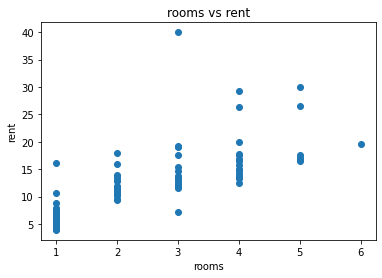

Correlation: 0.6929273993425428


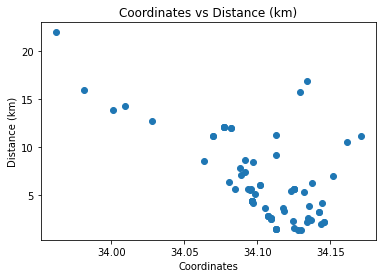

Correlation: -0.6143451255042779


In [ ]:
from scipy.stats import pearsonr
# since there are some rws that have an error in their coordinates, but they are not a majority, we are going to remove these to 
# be able to do a pearson correlation
df_study = df[df.Coordinates != 'Error']

# for encoding strings into numbers
def encoding(col,df):
    df_study = df
    encoding = lambda i:dict(enumerate(set(list(df_study[i]))))
    encoding = {v:k for k,v in encoding(col).items()}
    return [encoding[i] for i in df_study[col]]


encoding_coord = lambda col:[np.mean(i) for i in df_study[col]]

# investigate the correlations the different features have with each other

def feature_correlations(df_study,plot=True):
    checked,columns,correlations = [],list(df_study.columns),{k:[] for k in df_study.columns}

    for i in range(len(df_study.columns)):
        for j in range(len(df_study.columns)):
            if i != j and i != 0:
                if j not in checked:
                    
                    # print(columns[i],'vs',columns[j])                
                    
                    x,y = list(df_study[columns[i]]),list(df_study[columns[j]])
                    if type(x[0]) == str:
                        x = encoding(columns[i],df=df_study)
                    if type(y[0]) == str:
                        y = encoding(columns[j],df=df_study)                    
                    if type(x[0]) == tuple:
                        x = encoding_coord(columns[i])
                    if type(y[0]) == tuple:
                        y = encoding_coord(columns[j])                                        

                    correlation_coefficient, p_value = pearsonr(x, y)
                    
                    # add to dictionary to have the corrleations of the features with each other in a dic
                    correlations[columns[i]].append({columns[j]:correlation_coefficient})
                    
                    if plot:
                        if correlation_coefficient >= 0.5 or correlation_coefficient <= -0.5:
                            plt.scatter(x,y)
                            plt.xlabel(columns[i])
                            plt.ylabel(columns[j])
                            plt.title('{} vs {}'.format(columns[i],columns[j]))
                            plt.show()
                            print('Correlation:',correlation_coefficient)

            checked.append(i)
    return correlations

correlations = feature_correlations(df_study,plot=True)

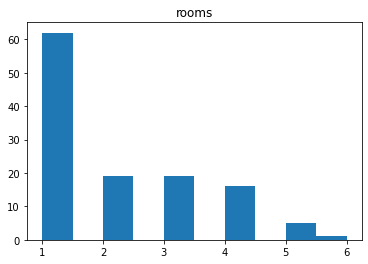

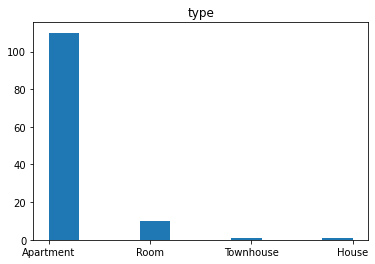

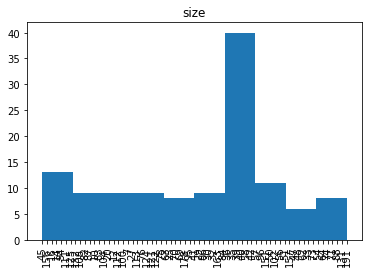

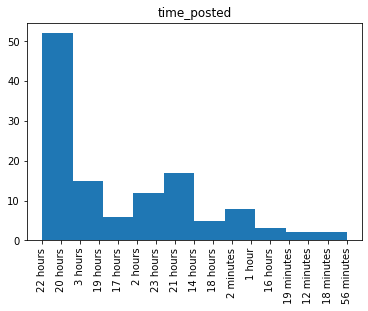

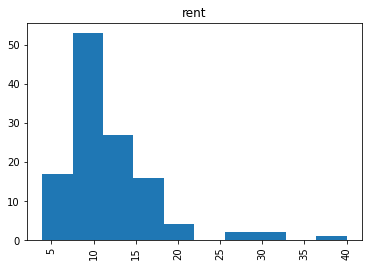

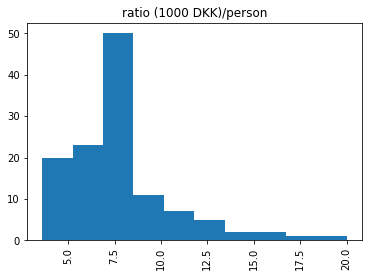

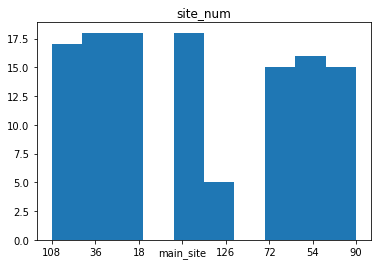

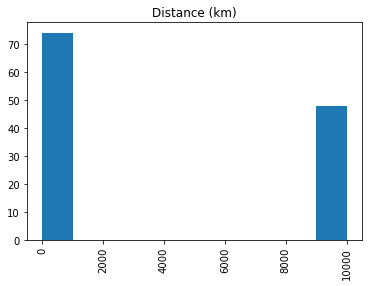

In [ ]:
def feature_distributions():
    c = ['rooms','type','size','time_posted','rent','ratio (1000 DKK)/person','site_num','Distance (km)']
    for i in c:    
        try:
            plt.hist(df[i])
            plt.title(i)
            if len(set(list(df[i]))) > 15:
                plt.xticks(rotation=90)        
            plt.show()

        except:
            l = [x for x in df[i] if not isinstance(x,str)]
            plt.hist(l)
            plt.title(i)
            plt.show()        
feature_distributions()            

This can be used to find the webapge of a place. All all the details of the url can be found in the dataset. All I need is the id of the location. This is where I iterate through all possible numbers until i find the right one. To ru all the functions you jsut have to run the last function :)

In [ ]:
# make a dictionary with all the required information for the url. All you must do i give the row index as an argument
def url_arguments_dic(df,n=0):
    row = n
    url_dic = {'type':0,'size':0,'n_rooms':0,'id':0}
    if df.iloc[row].type == 'Apartment':
        url_dic['type'] = 'apartments'
    elif df.iloc[row].type == 'Room':
        url_dic['type'] = 'rooms'
    url_dic['size'] = df.iloc[row]['size']
    url_dic['n_rooms'] = int(df.iloc[row]['rooms'])
    url_dic['id'] = int(df.iloc[row]['id'])
    return url_dic


# now out the two functions together in this one to get the info from the page
def apartments_extra_info_extraction(df,n=0):
    d = url_arguments_dic(df=df,n=n)
    print(d)
    url = "https://www.boligportal.dk/en/rental-{}/k%C3%B8benhavn/{}m2-{}-room-id-{}".format(d['type'],d['size'],d['n_rooms'],d['id'])
    print(url)
    response = requests.get(url)

    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(response.text, "html.parser")    
    sharable = soup.find_all('div',class_='css-h1x6rg')

    info = {}
    for i in sharable:
        try:
            info_type = i.find_all('span',class_='css-arxwps')[0].text
            info_answ = i.find_all('span',class_='css-1h46kg2')[0].text
            info[info_type] = info_answ
        except: pass    
    return info

# to run all the functions above all you have to do is run this one. There is no need to touch anything else
extra_info_dic = apartments_extra_info_extraction(df=df,n=0)
extra_info_dic

{'type': 'apartments', 'size': '150', 'n_rooms': 4, 'id': 5363395}
https://www.boligportal.dk/en/rental-apartments/k%C3%B8benhavn/150m2-4-room-id-5363395


{'Property type': 'Apartment',
 'Size': '150 m²',
 'Rooms': '4',
 'Floor': '1st ',
 'Furnished': 'No',
 'Shareable': 'No',
 'Pets allowed': 'No',
 'Elevator': 'No',
 'Senior friendly': 'No',
 'Students only': 'No',
 'Balcony': 'No',
 'Parking': 'No',
 'Energy rating': '-',
 'Rental period': '1-11 months',
 'Available from': 'As soon as possible',
 'Monthly net rent': '10.455 kr.',
 'Utilities': '1.200 kr.',
 'Deposit': '30.000 kr.',
 'Prepaid rent': '0 kr.',
 'Move-in price': '41.655 kr.',
 'Creation Date': '04/06/2023',
 'Listing-id': '5363395'}